In [32]:
# ## 06/20/2023:
# - code in the reading of plate locations from reader data
# - parse plates using code from AM_rescreen_S23
# - new selection algorithm to get top n hits from each plate

In [33]:
from screenTools import *
from pathlib import Path

In [34]:
# originally from AM_rescreen_S23

def importPlates(
    xls_path: Str,
    plate_list: list,
    peptide_list: list,
    positive_controls: list = [["A1", "B1", "C1"], ["A1", "B1", "C1"]], # these are the positive controls for each plate
    negative_controls: list = [["D1", "E1", "F1"], ["D1", "E1", "F1"]], # these are the negative controls for each plate
):
    """
    Imports a 384 well plate from an excel file. The first 12 columns are designated as plate 1 and
    the last 12 columns are designated as plate 2. Alternating rows are designated
    as substrate 1 and 2 respectively. The plate is then parsed into a list of 384 well plates.
    Parameters
    ----------
    xls_path : Str
        Path to the excel file containing the plate data.
    plate_list : list
        List of plate numbers. The first plate number corresponds to the first 96 wells of the plate.
    peptide_list : list
        List of peptides. The first peptide corresponds to the first 96 wells of the plate.
    positive_controls : list, optional
        List of positive control wells. The first list corresponds to the first plate and the second list corresponds to the second plate. The default is [["A1", "B1", "C1"], ["A1", "B1", "C1"]].
    negative_controls : list, optional
        List of negative control wells. The first list corresponds to the first plate and the second list corresponds to the second plate. The default is [["D1", "E1", "F1"], ["D1", "E1", "F1"]].
    Returns
    -------
    plates : list
        List of 384 well plates.
    """
    print("importing: ", xls_path)
    # upper_left_location = (50, 2) # these should be right if the plate reader saved correctly
    upper_left_location = (52, 2) # these should be right if the plate reader saved correctly
    lower_right_location = (67, 25)

    df = pd.read_excel(xls_path)
    plate_df = df.iloc[
        upper_left_location[0] - 1 : lower_right_location[0],
        upper_left_location[1] : lower_right_location[1] + 1,
    ] # this is the dataframe of the plate with the shape (16, 24)

    plates = parsePlate384(
        plate_df, 
        plate_list, 
        peptide_list, 
        positive_controls=positive_controls, 
        negative_controls=negative_controls
        )

    return plates

def parsePlate384(plate_df: pd.DataFrame, 
                  plate_list: list, 
                  peptide_list: list, 
                  positive_controls: list = [['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']], 
                  negative_controls: list = [['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]
                  ):
    """
    Parses a 384 well plate. The first 12 columns are designated as plate 1 and
    the last 12 columns are designated as plate 2. Alternating rows are designated
    as substrate 1 and 2 respectively.
    """
    # get the first 12 columns of plate_df. These contain plate 1.
    plate_1 = plate_df.iloc[:, :12]
    # get the last 12 columns of plate_df. These contain plate 2.
    plate_2 = plate_df.iloc[:, 12:]
    # get the first set of alternating rows of plate_1. These contain substrate 1.
    plate_1_sub1 = plate_1.iloc[::2, :]
    # get the second set of alternating rows of plate_1. These contain substrate 2.
    plate_1_sub2 = plate_1.iloc[1::2, :]
    # get the first set of alternating rows of plate_2. These contain substrate 1.
    plate_2_sub1 = plate_2.iloc[::2, :]
    # get the second set of alternating rows of plate_2. These contain substrate 2.
    plate_2_sub2 = plate_2.iloc[1::2, :]

    # parse each plate as a 96 well plate
    plate_1_sub1 = parsePlate(plate_1_sub1)
    plate_1_sub2 = parsePlate(plate_1_sub2)
    plate_2_sub1 = parsePlate(plate_2_sub1)
    plate_2_sub2 = parsePlate(plate_2_sub2)

    # assign control wells to each plate
    plate_1_sub1 = assignControls(plate_1_sub1, positive=positive_controls[0], negative=negative_controls[0])
    plate_1_sub2 = assignControls(plate_1_sub2, positive=positive_controls[0], negative=negative_controls[0])
    plate_2_sub1 = assignControls(plate_2_sub1, positive=positive_controls[1], negative=negative_controls[1])
    plate_2_sub2 = assignControls(plate_2_sub2, positive=positive_controls[1], negative=negative_controls[1])

    # add the plate number and peptide to each plate
    plate_1_sub1["plate_number"] = plate_list[0]
    plate_1_sub1["peptide"] = peptide_list[0]
    plate_1_sub2["plate_number"] = plate_list[0]
    plate_1_sub2["peptide"] = peptide_list[1]
    plate_2_sub1["plate_number"] = plate_list[1]
    plate_2_sub1["peptide"] = peptide_list[0]
    plate_2_sub2["plate_number"] = plate_list[1]
    plate_2_sub2["peptide"] = peptide_list[1]
    

    # # now expand the plates into a list of wells
    # plate_1_sub1 = expandPlate(plate_1_sub1, plate_list[0], peptide_list[0])
    # plate_1_sub2 = expandPlate(plate_1_sub2, plate_list[0], peptide_list[1])
    # plate_2_sub1 = expandPlate(plate_2_sub1, plate_list[1], peptide_list[0])
    # plate_2_sub2 = expandPlate(plate_2_sub2, plate_list[1], peptide_list[1])

    # concatenate the plates into a single dataframe
    plate_df = pd.concat([plate_1_sub1, plate_1_sub2, plate_2_sub1, plate_2_sub2])

    return plate_df

In [35]:
# test with emmas data
df = importPlates('./data/SU23_N8/ERR/Plates7and8EmmaR.5.30.23.xlsx', 
             ['E','F'], 
             [86,104], 
             positive_controls=[['A1', 'B1', 'C1'], ['A12', 'B12', 'C12']], 
             negative_controls=[['D1', 'E1', 'F1'], ['D12', 'E12', 'F12']])

importing:  ./data/SU23_N8/ERR/Plates7and8EmmaR.5.30.23.xlsx


In [36]:
# now do JB's hits
# import the plates
plates = [
importPlates('./data/SU23_N8/JB/052623_plate1and2.xlsx',
                 [1, 2],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/052623_plates5and6.xlsx',
                 [5, 6],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/053123_juli_plates3and4.xlsx',
                 [3, 4],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['D1', 'E1', 'F1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['A1', 'B1', 'C1']]),
importPlates('./data/SU23_N8/JB/060123_juli_plates7and8.xlsx',
                 [7, 8],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/060223_juli_plates9and10.xlsx',
                 [9, 10],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/060523_juli_plates11and12.xlsx',
                 [11, 12],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['B1', 'C1', 'D1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['E1', 'F1', 'G1']]),
importPlates('./data/SU23_N8/JB/060723_juli_plates13and14-LOW CONTROL.xlsx',
                 [13, 14],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/060823_juli_plates15and16-low control.xlsx',
                 [15, 16],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/060823_juli_plates17and18.xlsx',
                 [17, 18],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/060923_juli_plates19and20.xlsx',
                 [19, 20],
                 [86, 104], 
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/060923_juli_plates21and22 -13 AND 14 REMAKE.xlsx',
                 [21, 22],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/061323_juli_plates23and24- 15 AND 16 REMAKE.xlsx',
                 [23, 24],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/061523_juli_plates27and28.xlsx',
                 [27, 28],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
importPlates('./data/SU23_N8/JB/061623_juli_plates29and30.xlsx',
                 [29, 30],
                 [86, 104],
                 positive_controls=[['A1', 'B1', 'C1'], ['A1', 'B1', 'C1']],
                 negative_controls=[['D1', 'E1', 'F1'], ['D1', 'E1', 'F1']]),
]

importing:  ./data/SU23_N8/JB/052623_plate1and2.xlsx
importing:  ./data/SU23_N8/JB/052623_plates5and6.xlsx
importing:  ./data/SU23_N8/JB/053123_juli_plates3and4.xlsx
importing:  ./data/SU23_N8/JB/060123_juli_plates7and8.xlsx
importing:  ./data/SU23_N8/JB/060223_juli_plates9and10.xlsx
importing:  ./data/SU23_N8/JB/060523_juli_plates11and12.xlsx
importing:  ./data/SU23_N8/JB/060723_juli_plates13and14-LOW CONTROL.xlsx
importing:  ./data/SU23_N8/JB/060823_juli_plates15and16-low control.xlsx
importing:  ./data/SU23_N8/JB/060823_juli_plates17and18.xlsx
importing:  ./data/SU23_N8/JB/060923_juli_plates19and20.xlsx
importing:  ./data/SU23_N8/JB/060923_juli_plates21and22 -13 AND 14 REMAKE.xlsx
importing:  ./data/SU23_N8/JB/061323_juli_plates23and24- 15 AND 16 REMAKE.xlsx
importing:  ./data/SU23_N8/JB/061523_juli_plates27and28.xlsx
importing:  ./data/SU23_N8/JB/061623_juli_plates29and30.xlsx


In [37]:
# concatenate the plates
df = pd.concat(plates)

# replace zeros in the 'value' column with 1
df['value'] = df['value'].replace(0, 1)

# pivot the plates
pivot = df.pipe(pivotPlates).pipe(computeRatios)

In [38]:
pivot.sample(10)

plate_number row column     condition   value            86/104  \
peptide                                            86     104             
654                7   G      4  experimental   67453    2146  1.497372   
1856              20   C      6  experimental  446088   48611  0.962686   
2543              29   D      9  experimental    5202     126  1.615800   
2569              29   G     10  experimental   48356    1513  1.504611   
206                3   B     11  experimental    4120      63  1.815557   
281                3   H      3  experimental     803      16  1.700596   
1012              11   E      2  experimental  141334    4282  1.518600   
2240              24   C      6  experimental  283273    6574  1.634375   
1787              19   E      9  experimental  160014  122345  0.116572   
207                3   B     12  experimental  131231    1808  1.860838   

           104/86  
peptide            
654     -1.497372  
1856    -0.962686  
2543    -1.615800  
2569    -1.504611  
206     -1.815557  
281     -1.700596  
1012    -1.518600  
2240    -1.634375  
1787    -0.116572  
207     -1.860838

In [39]:
# find hits on a per-plate basis by ranking selectivity
def top_n_hits(plate_df, pep0n, pep1n, n=10, stdev_threshold=1):
    """
    Returns the top n hits for each plate in a dataframe.
    """
    # make the ratio strings
    ratiostr0 = str(pep0n) + "/" + str(pep1n)
    ratiostr1 = str(pep1n) + "/" + str(pep0n)

    # calculate the thresholds for each peptide by calculating the mean and adding a multiple of the standard deviation
    pep0_threshold = plate_df['value'][pep0n].mean() + stdev_threshold * plate_df['value'][pep0n].std()
    pep1_threshold = plate_df['value'][pep1n].mean() + stdev_threshold * plate_df['value'][pep1n].std()
    print("Thresholding plate", plate_df['plate_number'].unique()[0], "at", pep0_threshold, "for", pep0n,"and", pep1_threshold, "for", pep1n)

    # drop control wells
    plate_df = plate_df[plate_df['condition'] == 'experimental']

    # sort by selectivity for pep0
    pep0 = plate_df.sort_values(ratiostr0, ascending=False)
    # drop any values below the threshold and take the top n
    pep0 = pep0[pep0['value'][pep0n] > pep0_threshold].head(n)
    pep0['to_pick'] = pep0n
    
    # sort by selectivity for pep1
    pep1 = plate_df.sort_values(ratiostr1, ascending=False)
    # drop any values below the threshold and take the top n
    pep1 = pep1[pep1['value'][pep1n] > pep1_threshold].head(n)
    pep1['to_pick'] = pep1n

    # concatenate the two dataframes
    hits = pd.concat([pep0, pep1])

    # print plate number and number of hits if less than n*2
    if len(hits) < n*2:
        print("Only found", len(hits), "hits on plate", plate_df['plate_number'].unique()[0])

    return hits
    

In [40]:
top_n_hits(pivot[pivot['plate_number']==3], 86, 104, n=10, stdev_threshold=-0.5)

Thresholding plate 3 at 77702.1376916052 for 86 and 7076.753542042861 for 104


plate_number row column     condition   value            86/104  \
peptide                                            86     104             
207                3   B     12  experimental  131231    1808  1.860838   
272                3   G      6  experimental  136095    2647  1.711088   
282                3   H      4  experimental  282034    5589  1.702967   
273                3   G      7  experimental   86480    2315  1.572365   
205                3   B     10  experimental  103742    2832  1.563861   
220                3   C      2  experimental  324113    9060  1.553568   
218                3   C     11  experimental  160751    4618  1.541700   
201                3   A      7  experimental  184766    6017  1.487242   
210                3   B      4  experimental  399297   14833  1.430067   
239                3   D      9  experimental  266691   10032  1.424621   
198                3   A      4  experimental  272682  152977  0.251030   
269                3   G      3  experimental  204694  109883  0.270175   
284                3   H      6  experimental  217269   95988  0.354781   
271                3   G      5  experimental  271869  114430  0.375820   
203                3   A      9  experimental  366044  142855  0.408638   
244                3   E      2  experimental  290840   90674  0.506171   
209                3   B      3  experimental  326797   85505  0.582287   
230                3   D     11  experimental  381971   92494  0.615917   
264                3   G      1  experimental  282862   65223  0.637174   
275                3   G      9  experimental  369010   80266  0.662507   

           104/86 to_pick  
peptide                    
207     -1.860838      86  
272     -1.711088      86  
282     -1.702967      86  
273     -1.572365      86  
205     -1.563861      86  
220     -1.553568      86  
218     -1.541700      86  
201     -1.487242      86  
210     -1.430067      86  
239     -1.424621      86  
198     -0.251030     104  
269     -0.270175     104  
284     -0.354781     104  
271     -0.375820     104  
203     -0.408638     104  
244     -0.506171     104  
209     -0.582287     104  
230     -0.615917     104  
264     -0.637174     104  
275     -0.662507     104

In [41]:
# now do this for all the plates
hits = []
for plate in pivot['plate_number'].unique():
    hits.append(top_n_hits(pivot[pivot['plate_number']==plate], 86, 104, n=10, stdev_threshold=-0.5))
# concatenate the hits
hits = pd.concat(hits)
hits

Thresholding plate 1 at 42570.456935720285 for 86 and 10806.098523963512 for 104
Thresholding plate 2 at 81989.71020262959 for 86 and 17802.619659145956 for 104
Thresholding plate 3 at 77702.1376916052 for 86 and 7076.753542042861 for 104
Thresholding plate 4 at 116905.76306748745 for 86 and 11047.575038620918 for 104
Thresholding plate 5 at 81087.19298264605 for 86 and 17499.245038394587 for 104
Thresholding plate 6 at 77847.59194506351 for 86 and 14558.460237340969 for 104
Thresholding plate 7 at 72979.6708655414 for 86 and 28673.773101993786 for 104
Thresholding plate 8 at 151887.68713205165 for 86 and 15486.51284793931 for 104
Thresholding plate 9 at 59072.20390618344 for 86 and 21942.787442062385 for 104
Thresholding plate 10 at 101185.22150039277 for 86 and 17418.06961578004 for 104
Thresholding plate 11 at 48466.78644067794 for 86 and 20599.89333348799 for 104
Thresholding plate 12 at 42492.0616054823 for 86 and 8627.745782101796 for 104
Thresholding plate 13 at 31310.3417808058

plate_number row column     condition   value           86/104  \
peptide                                            86    104             
79                 1   G      5  experimental   55871    198  2.450521   
39                 1   D     12  experimental   74745    843  1.947755   
92                 1   H      6  experimental   74590   1130  1.819602   
61                 1   F     10  experimental   93512   3671  1.406083   
74                 1   G     11  experimental  211049   9214  1.359935   
...              ...  ..    ...           ...     ...    ...       ...   
2646              30   E      4  experimental  138601  61077  0.355889   
2657              30   F      3  experimental  161803  51306  0.498818   
2659              30   F      5  experimental  234113  68935  0.530986   
2684              30   H      6  experimental  184989  53726  0.536961   
2633              30   D      3  experimental  237317  65998  0.555798   

           104/86 to_pick  
peptide                    
79      -2.450521      86  
39      -1.947755      86  
92      -1.819602      86  
61      -1.406083      86  
74      -1.359935      86  
...           ...     ...  
2646    -0.355889     104  
2657    -0.498818     104  
2659    -0.530986     104  
2684    -0.536961     104  
2633    -0.555798     104  

[560 rows x 9 columns]

<Axes: xlabel='86', ylabel='104'>

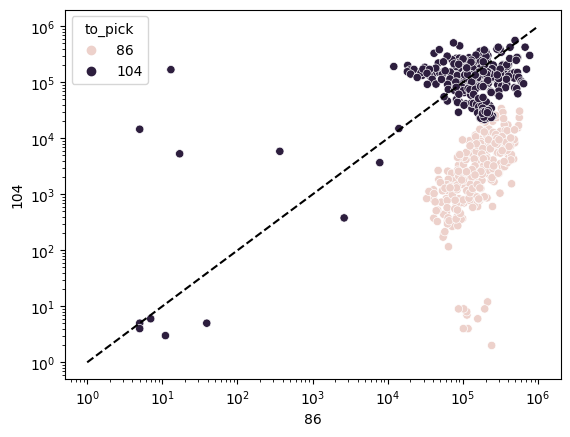

In [42]:
# plot with a scatter plot with 86 on the x axis and 104 on the y axis and color by to_pick
# log scale the axes
plt.xscale('log')
plt.yscale('log')
# draw a line at y=x
plt.plot([1, 1000000], [1, 1000000], color='black', linestyle='--')
sns.scatterplot(data=hits, x=hits['value'][86], y=hits['value'][104], hue='to_pick')

<Axes: xlabel='86', ylabel='104'>

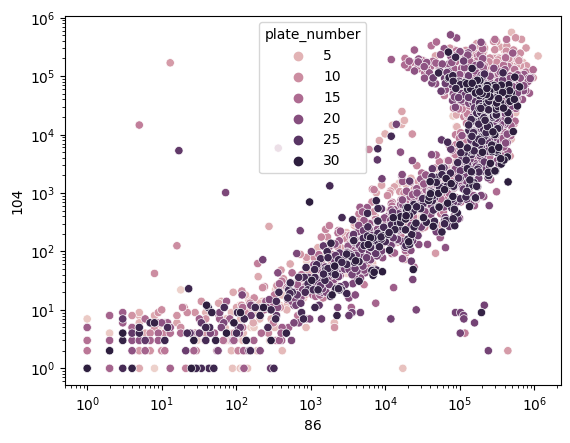

In [43]:
# plot the pivot dataframe in the same way without the hits
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(data=pivot, x=pivot['value'][86], y=pivot['value'][104], hue='plate_number')

In [44]:
# prep and output hits as a csv output 160 at a time
def to_pick_csv(hits, file_prefix='to_pick'):
    # cast the plate_number column as an int
    hits['plate_number'] = hits['plate_number'].astype(int)
    # sort by plate_number
    hits = hits.sort_values('plate_number')
    # for each plate_number in the hits dataframe, add a new column with the deck position, starting at 1 and repeating after 8
    d = {hits['plate_number'].unique()[i]: i%8+1 for i in range(len(hits['plate_number'].unique()))}
    hits['deck_position'] = hits['plate_number'].map(d)

    # rename the plate_number column to plate_label
    hits = hits.rename(columns={'plate_number': 'plate_label'})
    # keep only the columns we want: to_pick, deck_position, row, column, and plate_label in that order
    hits = hits[['to_pick', 'deck_position', 'row', 'column', 'plate_label']]

    # output the hits as a csv file, splitting into a new file every eight unique plate_labels
    labels = hits['plate_label'].unique()
    for i in range(0, len(labels), 8):
        hits[hits['plate_label'].isin(labels[i:i+8])].to_csv(file_prefix + "_" + str(i) + ".csv", index=True)

    return hits



In [45]:
to_pick_csv(hits, file_prefix='./data/SU23_N8/JB_to_pick')

,to_pick,deck_position,row,column,plate_label
peptide,,,,,
79,86,1,G,5,1
68,104,1,F,6,1
46,104,1,D,8,1
63,104,1,F,12,1
32,104,1,C,6,1
...,...,...,...,...,...
2676,86,4,H,1,30
2615,86,4,B,9,30
2684,104,4,H,6,30


Used these commands to export the data for Emma and Juli. Should fold in to the main method of screenTools eventually.